# Introduction

In this analysis, I will perform text classification on the ingame chat data in Dota 2 matches. Because of the competitive nature of this team based game, I suspect that the ingame chat history will contain a lot of toxic/salty comments depending if the players are winning or lossing. A breif introduction as well as an exploratory data analysis of game matches can be found [here](https://leyaof.github.io/Notebooks/dota%20analysis.nb.html).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
import random

In [39]:
# load dataset
columns = ["match_id", "player_slot", "chat", "unit", "radiant_win"]
data = pd.read_csv('match_chat2-534.csv', names=columns, encoding = "ISO-8859-1")

# Explore dataset

In [3]:
# display first few rows of the dataset
data.head()

,match_id,player_slot,chat,unit,radiant_win
0,5008241860,3,gl hf,3,0
1,5008241860,128,METROBOOMIN ON THE BEAT,5,0
2,5008241860,132,gg close game,9,0
3,5008241860,1,door,1,0
4,5008241860,1,1 sec,1,0


In [4]:
# number of rows in the dataset
len(data)

6370

In [5]:
# What is the shape of the dataset

print("Input data has {} rows and {} columns.".format(len(data), len(data.columns)))

Input data has 6370 rows and 5 columns.


In [6]:
# according to the API, player_slot 0-127 are Radiant, 128-255 are Dire
data['is_radiant'] = np.where(data['player_slot']<=127, 1, 0)
# create a new column call win
win_condition = (data['is_radiant'] == data['radiant_win'])
data['win'] = np.where(win_condition, 1, 0)
data.head()

,match_id,player_slot,chat,unit,radiant_win,is_radiant,win
0,5008241860,3,gl hf,3,0,1,0
1,5008241860,128,METROBOOMIN ON THE BEAT,5,0,0,1
2,5008241860,132,gg close game,9,0,0,1
3,5008241860,1,door,1,0,1,0
4,5008241860,1,1 sec,1,0,1,0


In [7]:
chat_data = data.groupby(['match_id', 'win'])['chat'].apply(' '.join).reset_index()
chat_data.head()

,match_id,win,chat
0,2078532827,0,zZZ GG ARCAN PURA MRD REPORT SLARK CARRY NOOB ...
1,2078532827,1,ill take it Ty much appreicated duel him bro R...
2,2078604027,0,? fedeando clinck? Agradece al lag hjp no veo ...
3,2078604027,1,? wow illl take it shcakle of the year Gg hes ...
4,3251949218,0,LOL LOL lol gg gg I got one too :) gg


In [8]:
# drop match_id column
chat_data = chat_data.drop(columns=['match_id'], axis=1)
chat_data.head()

,win,chat
0,0,zZZ GG ARCAN PURA MRD REPORT SLARK CARRY NOOB ...
1,1,ill take it Ty much appreicated duel him bro R...
2,0,? fedeando clinck? Agradece al lag hjp no veo ...
3,1,? wow illl take it shcakle of the year Gg hes ...
4,0,LOL LOL lol gg gg I got one too :) gg


In [9]:
# How many wins/lost are there
print("Out of {} rows, {} are wins, {} are loses".format(len(chat_data),
                                                         len(chat_data[chat_data['win']==1]),
                                                         len(chat_data[chat_data['win']==0])))

Out of 746 rows, 392 are wins, 354 are loses


In [10]:
# are there any missing data

print("Number of null in win: {}".format(chat_data['win'].isnull().sum()))
print("Number of null in chat: {}".format(chat_data['chat'].isnull().sum()))

Number of null in win: 0
Number of null in chat: 0


In [11]:
# top 10 common words

freq_words = pd.Series(' '.join(chat_data['chat']).split()).value_counts()[:10]
freq_words

gg        605
?         307
ez        251
lol       197
you       184
report    169
i         127
a         126
no        123
to        117
dtype: int64

In [12]:
chat_data['chat_length'] = chat_data['chat'].apply(lambda x: len(x) -x.count(" "))


In [13]:
import string

def gg_count(text):
    text = text.lower()
    count = text.count('gg') + text.count('ez')
    return count

chat_data['gg count'] = chat_data["chat"].apply(lambda x: gg_count(x))

In [14]:
def report_count(text):
    text = text.lower()
    count = text.count('report')
    return count

chat_data['report count'] = chat_data["chat"].apply(lambda x : report_count(x))

In [15]:
def punctuation_percent(text):
    count = sum([1 for char in text if char in string.punctuation])
    percentage = round(count/(len(text)-text.count(" ")), 3)*100
    return percentage

chat_data['punctuation percent'] = chat_data["chat"].apply(lambda x: punctuation_percent(x))

In [16]:
def cap_percent(text):
    count = sum([1 for char in text if char.isupper()])
    percentage = round(count/(len(text)-text.count(" ")), 3)*100
    return percentage

chat_data['capitalized percent'] = chat_data["chat"].apply(lambda x: cap_percent(x))

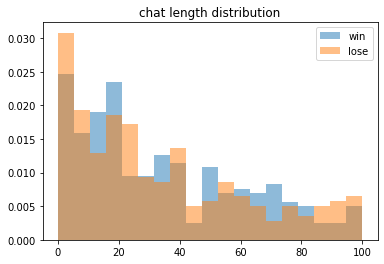

In [17]:
from matplotlib import pyplot
%matplotlib inline

bins = np.linspace(0, 100, 20)
pyplot.hist(chat_data[chat_data['win']==1]['chat_length'], bins, alpha=0.5, density=True, label="win")
pyplot.hist(chat_data[chat_data['win']==0]['chat_length'], bins, alpha=0.5, density=True, label="lose")
pyplot.legend(loc='upper right')
pyplot.title("chat length distribution")
pyplot.show()

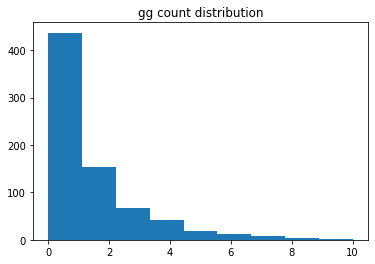

In [18]:
%matplotlib inline

bins = np.linspace(0, 10, 10)
pyplot.hist(chat_data['gg count'], bins)
#pyplot.hist(chat_data[chat_data['win']==0]['gg count'], bins, alpha=0.5, density=True, label="lose")
#pyplot.legend(loc='upper right')
pyplot.title("gg count distribution")
pyplot.show()

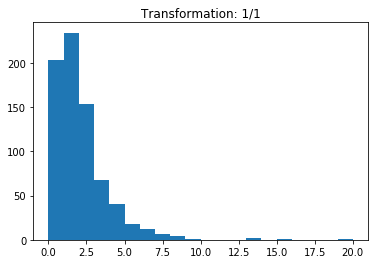

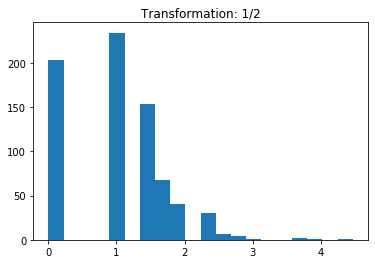

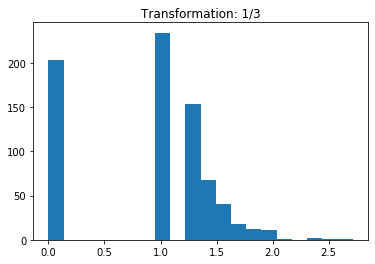

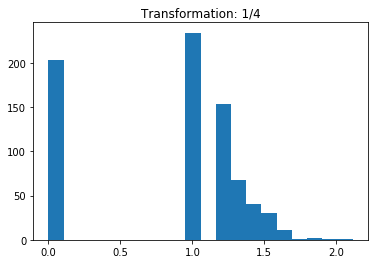

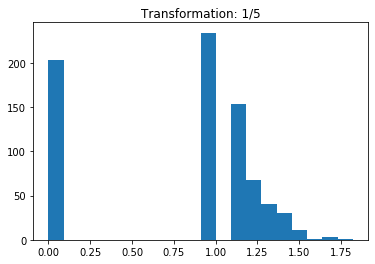

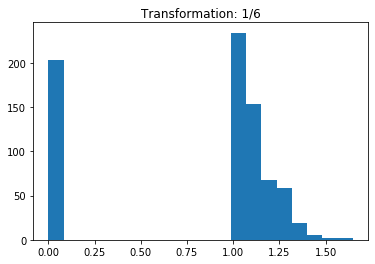

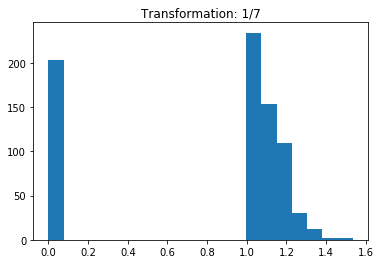

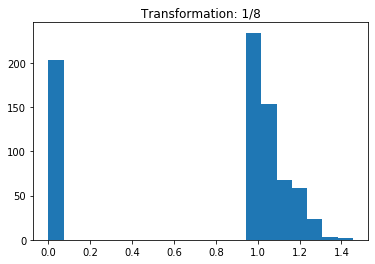

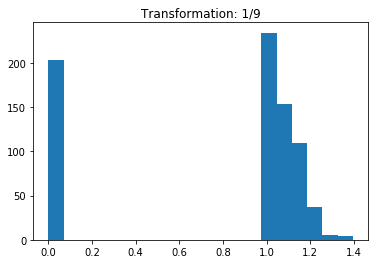

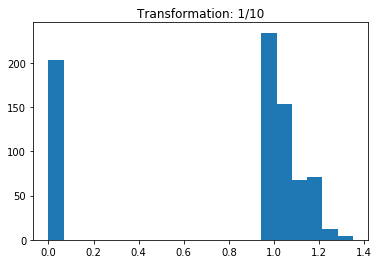

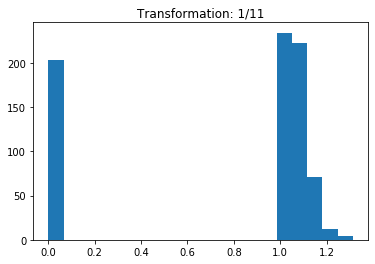

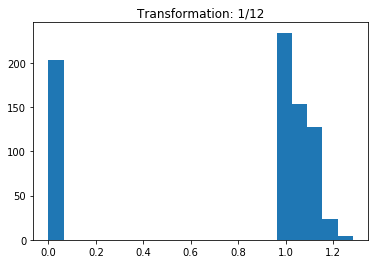

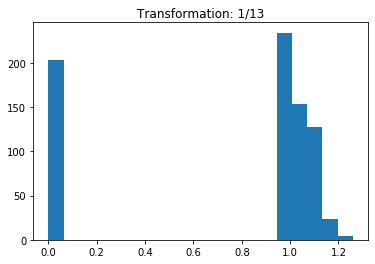

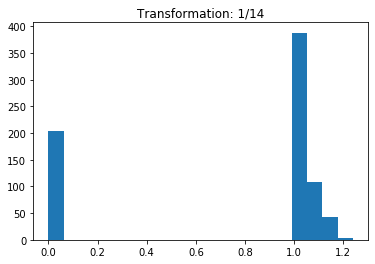

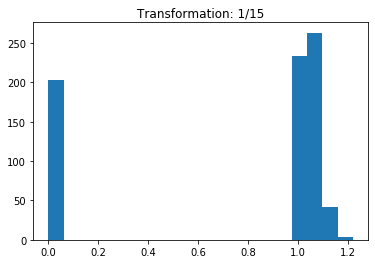

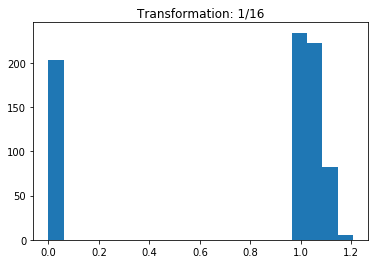

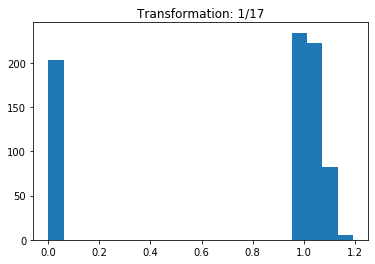

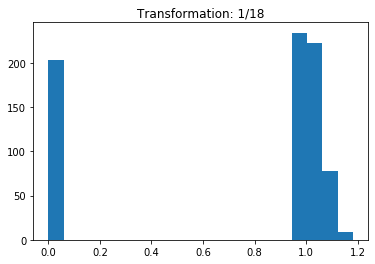

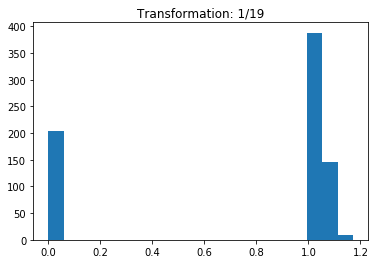

In [19]:
for i in range(1,20):
    pyplot.hist(chat_data['gg count']**(1/i), bins=20)
    pyplot.title("Transformation: 1/{}".format(str(i)))
    pyplot.show()

In [20]:
#chat_data['gg count'] = chat_data['gg count']**(1/11)

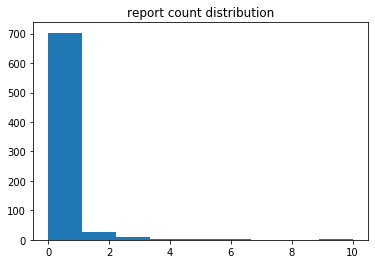

In [21]:
%matplotlib inline

bins = np.linspace(0, 10, 10)
pyplot.hist(chat_data['report count'], bins)
#pyplot.hist(chat_data[chat_data['win']==0]['report count'], bins, alpha=0.5, density=True, label="lose")
#pyplot.legend(loc='upper right')
pyplot.title("report count distribution")
pyplot.show()

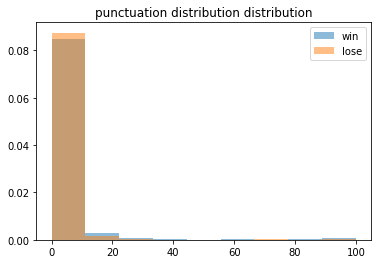

In [22]:
bins = np.linspace(0, 100, 10)
pyplot.hist(chat_data[chat_data['win']==1]['punctuation percent'], bins, alpha=0.5, density=True, label="win")
pyplot.hist(chat_data[chat_data['win']==0]['punctuation percent'], bins, alpha=0.5, density=True, label="lose")
pyplot.legend(loc='upper right')
pyplot.title("punctuation distribution distribution")
pyplot.show()

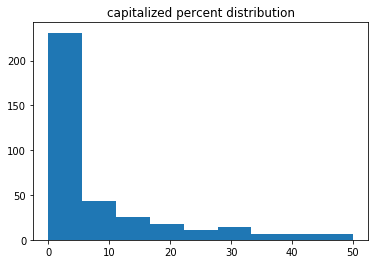

In [23]:
bins = np.linspace(0, 50, 10)
pyplot.hist(chat_data[chat_data['win']==1]['capitalized percent'], bins)
#pyplot.hist(chat_data[chat_data['win']==0]['capitalized percent'], bins, alpha=0.5, density=True, label="lose")
#pyplot.legend(loc='upper right')
pyplot.title("capitalized percent distribution")
pyplot.show()

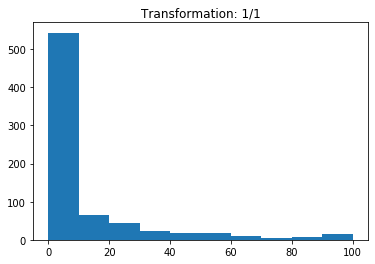

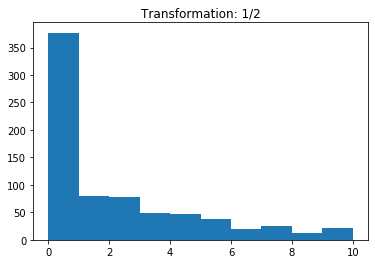

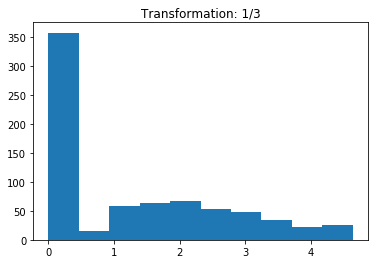

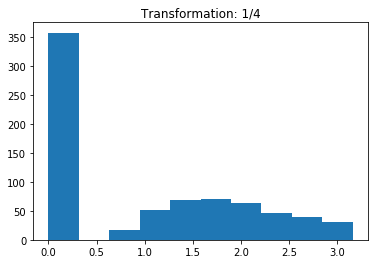

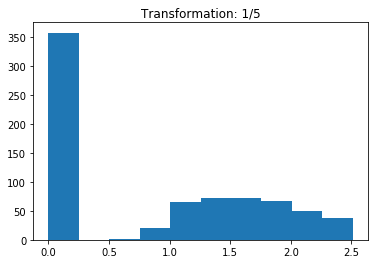

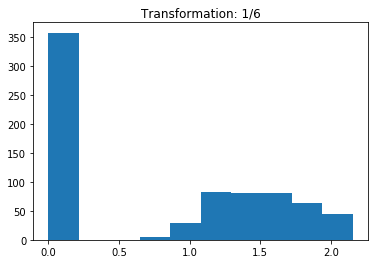

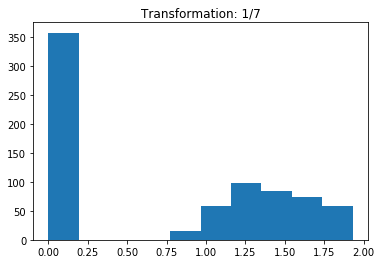

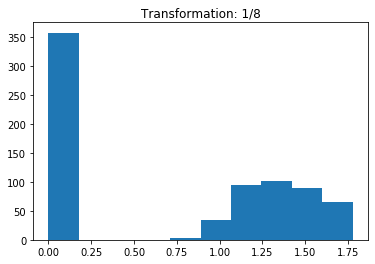

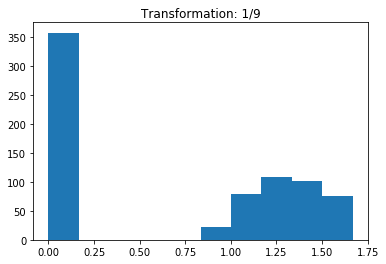

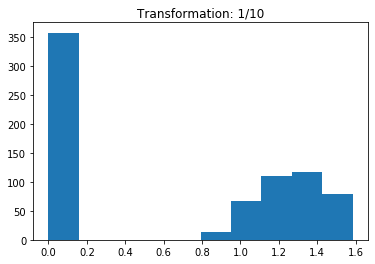

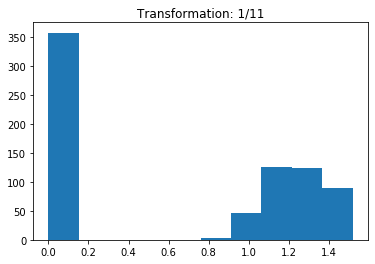

In [24]:
# capitalized percent has a long right tail
# Box-Cox Power Transformation
for i in range(1,12):
    pyplot.hist(chat_data['capitalized percent']**(1/i), bins=10)
    pyplot.title("Transformation: 1/{}".format(str(i)))
    pyplot.show()


In [25]:
#chat_data['capitalized percent'] = chat_data['capitalized percent']**(1/9)